# Mount drive and unzip data folder
- Note : Change runtime type to GPU

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# %cd '/content/drive/My Drive'
# !unzip 'DOG_CAT_SMALL.zip'

Mounted at /content/drive/
/content/drive/My Drive
Archive:  DOG_CAT_SMALL.zip
replace DOG_CAT_SMALL/train/dog/dog.6338.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
# !ls '/content/drive/My Drive/DOG_CAT_SMALL'

test  train


# Import libraries

In [77]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Some sklearn
from sklearn.metrics import accuracy_score, confusion_matrix

# Torch dependencies
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Create an image DataLoader (From custom dataset)
- Will be used in next tutorial

In [4]:
# Create a preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Create a dataset
dataset = datasets.ImageFolder('/content/drive/My Drive/DOG_CAT_SMALL/train/', transform=transform)

# Create a dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

[INFO] Number of batches in dataset : 313
[INFO] Batch size : 32
[INFO] Class IDs to Class names : {0: 'cat', 1: 'dog'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

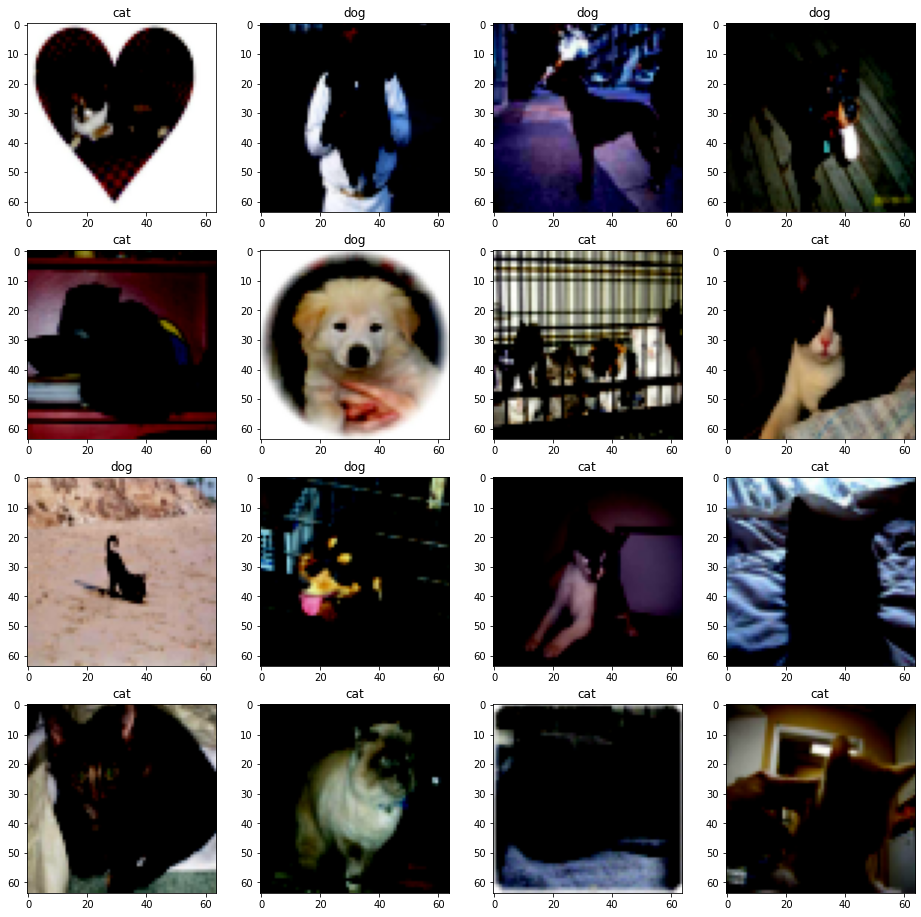

In [5]:
# Get some info from the data loader
num_batches = len(dataloader)
batch_size = dataloader.batch_size
class_names = dataset.class_to_idx
class_names = {y : x for x, y in class_names.items()}

print(f'[INFO] Number of batches in dataset : {num_batches}')
print(f'[INFO] Batch size : {batch_size}')
print(f'[INFO] Class IDs to Class names : {class_names}')

# Show sample images
images, labels = next(iter(dataloader))
fig, ax = plt.subplots(4, 4, figsize=(16,16))

for i in range(16):
    row = i // 4
    col = i % 4
    
    class_id = int(labels[i].detach().numpy())
    ax[row][col].imshow(images[i].permute(1,2,0))
    ax[row][col].set_title(class_names[class_id])
    
plt.show()

# Create a pre-built data loader from PyTorch

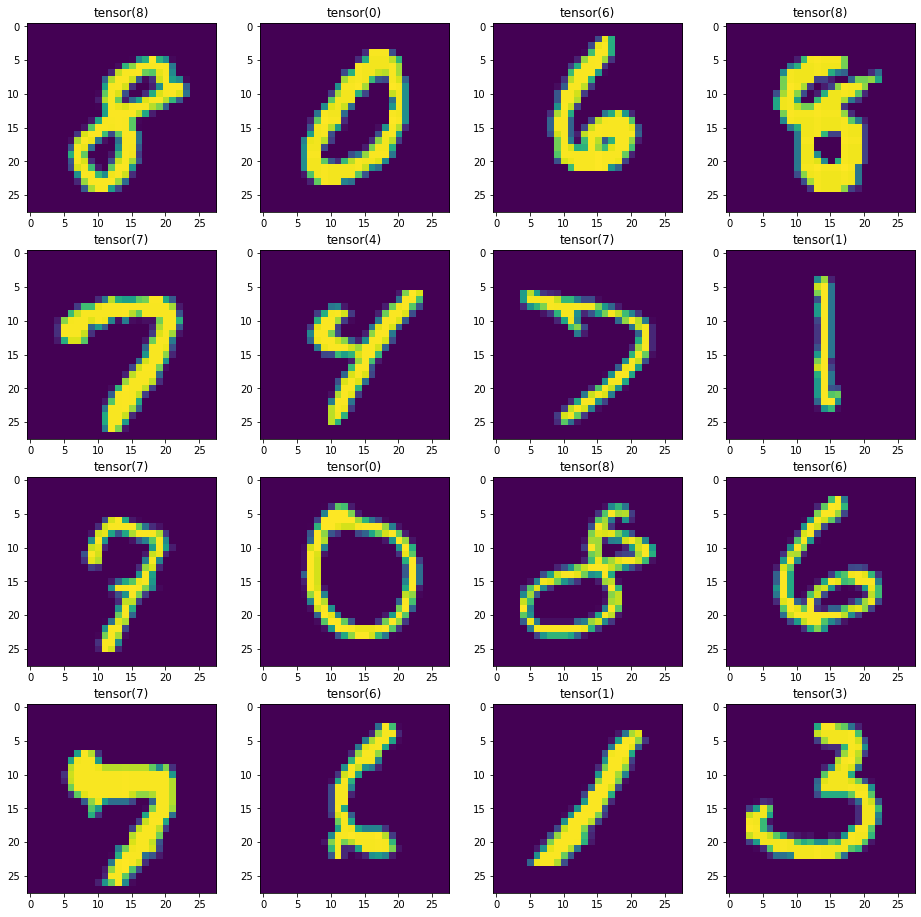

In [52]:
batch_size = 32
# MNIST dataset - should take around 5 minutes to download
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Show some images
images, labels = next(iter(train_loader))
images = images.permute(0,2,3,1)
images = images.detach().numpy().squeeze(3)
fig, ax = plt.subplots(4,4, figsize=(16, 16))

for i in range(16):
  row = i // 4
  col = i % 4

  ax[row][col].imshow(images[i])
  ax[row][col].set_title(labels[i])

plt.show()

# Create a convolutional neural network
#### Let's create a convolutional neural network with activation functions

In [58]:
'''CNN without batch normalization'''
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, n_classes=10):
        '''
            input_channels : Number of channels in the input image. 
                * Note : Channels in an image is the depth of the image. Number of channels will be 3 for colored 
                images like RGB, HSV, ... and 1 for grayscale images.
            n_classes : Number of classes to classify by.
        '''
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        # self.norm1 = nn.BatchNorm2d(16)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu1 = nn.ReLU()
        
        ''' Note : number of in_channels in the current layer must be equal to the out_channels of the previous layer'''
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # self.norm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU()
        
        ''' Fully connected layers '''
        self.fc = nn.Linear(in_features=7*7*32, out_features=64)
        self.hidden = nn.Linear(in_features=64, out_features=n_classes)

        ''' Note : You don't have to add log softmax in the output layer because cross entropy loss 
            calculates log sotmax of inputs before applying the NNLLoss
        '''
        # self.output = nn.LogSoftmax()
        
    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.maxpool1(outputs)
        # outputs = self.norm1(outputs)
        outputs = self.relu1(outputs)
        
        outputs = self.conv2(outputs)
        outputs = self.maxpool2(outputs)
        # outputs = self.norm2(outputs)
        outputs = self.relu2(outputs)

        outputs = torch.flatten(outputs, 1) # Flatten the convolutional layers' outputs to fit linear layer

        outputs = self.fc(outputs)
        outputs = self.hidden(outputs)
        # outputs = self.output(outputs)
        
        return outputs
    

# Test the model, should run if no errors occur
model = SimpleCNN(input_channels=3, n_classes=2)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (fc): Linear(in_features=1568, out_features=64, bias=True)
  (hidden): Linear(in_features=64, out_features=2, bias=True)
)


#### Define the training loop

In [59]:
# Switch to GPU if availabel
device = torch.device('cpu')
if(torch.cuda.is_available()):
    print('GPU is available')
    device = torch.device('cuda')
else:
    print('GPU is not available')
    
num_batches = len(train_loader) # Number of batches to train in one epoch
epochs = 3

# Prepare the loss and the model and the optimizer
model = SimpleCNN(input_channels=1, n_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device)

# Define an array to store the batch-wise losses
train_losses_1 = []

for i in range(epochs):
    for j, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_losses_1.append(loss.item())
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        if (j+1) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(i+1, epochs, j+1, num_batches, loss.item()))
            

GPU is available
Epoch [1/3], Step [50/1875], Loss: 0.4544
Epoch [1/3], Step [100/1875], Loss: 0.3530
Epoch [1/3], Step [150/1875], Loss: 0.3919
Epoch [1/3], Step [200/1875], Loss: 0.3146
Epoch [1/3], Step [250/1875], Loss: 0.2017
Epoch [1/3], Step [300/1875], Loss: 0.1029
Epoch [1/3], Step [350/1875], Loss: 0.1981
Epoch [1/3], Step [400/1875], Loss: 0.3303
Epoch [1/3], Step [450/1875], Loss: 0.0833
Epoch [1/3], Step [500/1875], Loss: 0.2392
Epoch [1/3], Step [550/1875], Loss: 0.0534
Epoch [1/3], Step [600/1875], Loss: 0.2044
Epoch [1/3], Step [650/1875], Loss: 0.0137
Epoch [1/3], Step [700/1875], Loss: 0.1367
Epoch [1/3], Step [750/1875], Loss: 0.3119
Epoch [1/3], Step [800/1875], Loss: 0.1041
Epoch [1/3], Step [850/1875], Loss: 0.0442
Epoch [1/3], Step [900/1875], Loss: 0.0973
Epoch [1/3], Step [950/1875], Loss: 0.0209
Epoch [1/3], Step [1000/1875], Loss: 0.1574
Epoch [1/3], Step [1050/1875], Loss: 0.1063
Epoch [1/3], Step [1100/1875], Loss: 0.2775
Epoch [1/3], Step [1150/1875], Loss

# Create a convolutional neural network with batch normalization

In [60]:
'''CNN with batch normalization'''
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, n_classes=10):
        '''
            input_channels : Number of channels in the input image. 
                * Note : Channels in an image is the depth of the image. Number of channels will be 3 for colored 
                images like RGB, HSV, ... and 1 for grayscale images.
            n_classes : Number of classes to classify by.
        '''
        super(SimpleCNN, self).__init__()
        
        # Input size = 32 x 32 x 3
        # First conv , output = 30 x 30 x 16
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        
        # First maxpool = 15 x 15 x 16
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu1 = nn.ReLU()
        
        ''' Note : number of in_channels in the current layer must be equal to the out_channels of the previous layer'''
        # 13 x 13 x 32
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(32)
        
        # 6 x 6 x 32
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU()
        
        ''' Fully connected layers '''
        self.fc = nn.Linear(in_features=7*7*32, out_features=64)
        self.hidden = nn.Linear(in_features=64, out_features=n_classes)

        ''' Note : You don't have to add log softmax in the output layer because cross entropy loss 
            calculates log sotmax of inputs before applying the NNLLoss
        '''
        
    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.maxpool1(outputs)
        outputs = self.norm1(outputs)
        outputs = self.relu1(outputs)
        
        outputs = self.conv2(outputs)
        outputs = self.maxpool2(outputs)
        outputs = self.norm2(outputs)
        outputs = self.relu2(outputs)

        outputs = torch.flatten(outputs, 1) # Flatten the convolutional layers' outputs to fit linear layer

        outputs = self.fc(outputs)
        outputs = self.hidden(outputs)
        
        return outputs
    

# Test the model, should run if no errors occur
model = SimpleCNN(input_channels=3, n_classes=2)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (fc): Linear(in_features=1568, out_features=64, bias=True)
  (hidden): Linear(in_features=64, out_features=2, bias=True)
)


In [61]:
# Switch to GPU if availabel
device = torch.device('cpu')
if(torch.cuda.is_available()):
    print('GPU is available')
    device = torch.device('cuda')
else:
    print('GPU is not available')
    
num_batches = len(train_loader) # Number of batches to train in one epoch
epochs = 3

# Prepare the loss and the model and the optimizer
model = SimpleCNN(input_channels=1, n_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device)

# Define an array to store the batch-wise losses
train_losses_2 = []

for i in range(epochs):
    for j, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_losses_2.append(loss.item())
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        if (j+1) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(i+1, epochs, j+1, num_batches, loss.item()))
            

GPU is available
Epoch [1/3], Step [50/1875], Loss: 0.3101
Epoch [1/3], Step [100/1875], Loss: 0.1110
Epoch [1/3], Step [150/1875], Loss: 0.0951
Epoch [1/3], Step [200/1875], Loss: 0.3229
Epoch [1/3], Step [250/1875], Loss: 0.0962
Epoch [1/3], Step [300/1875], Loss: 0.0683
Epoch [1/3], Step [350/1875], Loss: 0.1287
Epoch [1/3], Step [400/1875], Loss: 0.0633
Epoch [1/3], Step [450/1875], Loss: 0.0638
Epoch [1/3], Step [500/1875], Loss: 0.4304
Epoch [1/3], Step [550/1875], Loss: 0.0470
Epoch [1/3], Step [600/1875], Loss: 0.0073
Epoch [1/3], Step [650/1875], Loss: 0.1451
Epoch [1/3], Step [700/1875], Loss: 0.0031
Epoch [1/3], Step [750/1875], Loss: 0.0307
Epoch [1/3], Step [800/1875], Loss: 0.1759
Epoch [1/3], Step [850/1875], Loss: 0.1219
Epoch [1/3], Step [900/1875], Loss: 0.1406
Epoch [1/3], Step [950/1875], Loss: 0.0374
Epoch [1/3], Step [1000/1875], Loss: 0.0269
Epoch [1/3], Step [1050/1875], Loss: 0.0027
Epoch [1/3], Step [1100/1875], Loss: 0.0325
Epoch [1/3], Step [1150/1875], Loss

# Compare CNN with and without BN

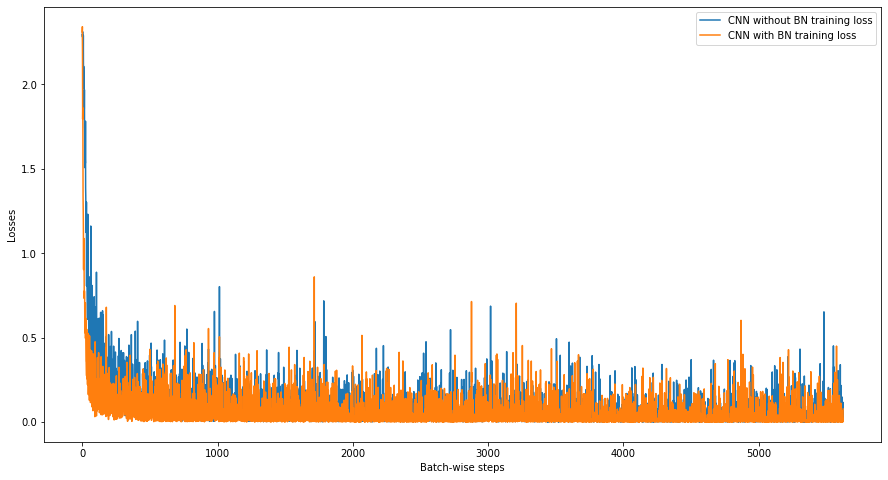

In [64]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(train_losses_1, label='CNN without BN training loss')
ax.plot(train_losses_2, label='CNN with BN training loss')

ax.set_xlabel('Batch-wise steps')
ax.set_ylabel('Losses')

plt.legend()
plt.show()

# Evaluate the neural network on testing dataset

In [80]:
all_predictions = np.array([])
all_labels = np.array([])

for j, (images, labels) in enumerate(train_loader):
  # Convert images and labels to our respective devices
  images = images.to(device)
  labels = labels.to(device)

  # Make predictions
  predictions = model(images)

  # Convert to numpy
  predictions = predictions.cpu().detach().numpy()
  labels = labels.cpu().detach().numpy()

  # Convert from one-hot labels to scalar labels
  predictions = np.argmax(predictions, axis=1)

  # Concatenate current predictions to the overall predictions
  all_predictions = np.concatenate([all_predictions, predictions])
  all_labels = np.concatenate([all_labels, labels])

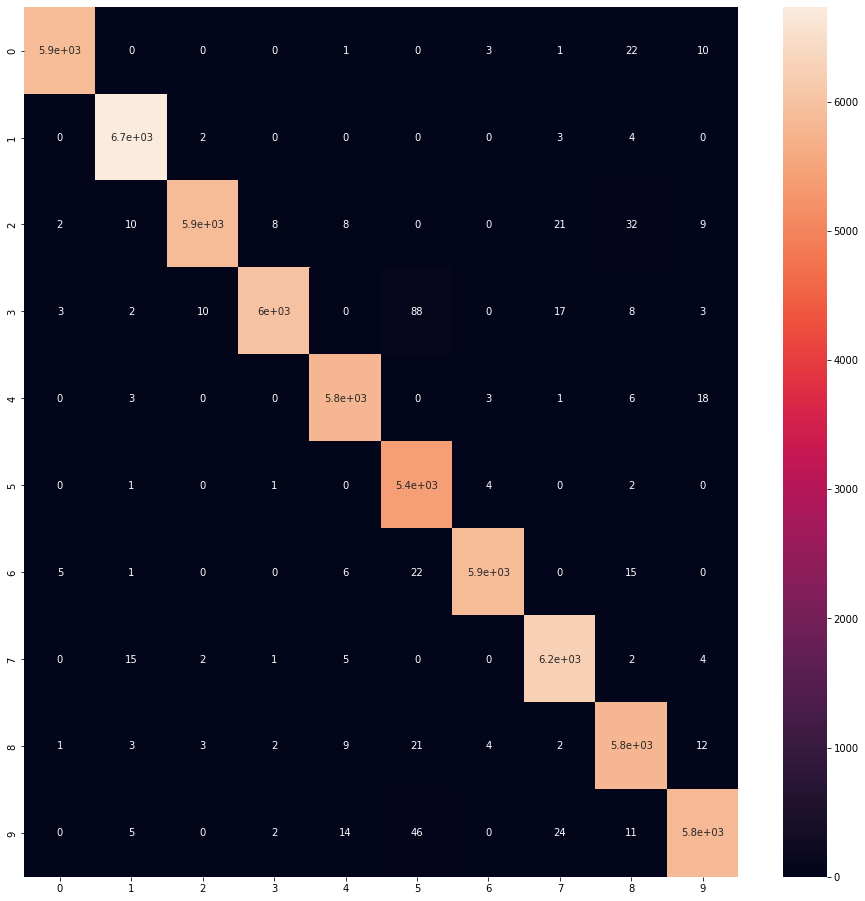

In [79]:
conf_matrix = confusion_matrix(all_labels, all_predictions)

fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(conf_matrix, ax=ax, annot=True)
plt.show()

In [81]:
overall_accuracy = accuracy_score(all_labels, all_predictions)
print('Overall accuracy = ', overall_accuracy)

Overall accuracy =  0.9910333333333333
